In [48]:
! pip install xgboost

   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
    --------------------------------------- 2.4/149.9 MB 16.8 MB/s eta 0:00:09
   - -------------------------------------- 5.5/149.9 MB 16.0 MB/s eta 0:00:10
   -- ------------------------------------- 8.7/149.9 MB 15.8 MB/s eta 0:00:09
   --- ------------------------------------ 11.8/149.9 MB 15.7 MB/s eta 0:00:09
   --- ------------------------------------ 14.9/149.9 MB 15.4 MB/s eta 0:00:09
   ---- ----------------------------------- 18.4/149.9 MB 15.6 MB/s eta 0:00:09
   ----- ---------------------------------- 21.5/149.9 MB 15.4 MB/s eta 0:00:09
   ------ --------------------------------- 24.6/149.9 MB 15.4 MB/s eta 0:00:09
   ------- -------------------------------- 27.8/149.9 MB 15.5 MB/s eta 0:00:08
   -------- ------------------------------- 31.2/149.9 MB 15.5 MB/s eta 0:00:08
   --------- ------------------------------ 34.3/149.9 MB 15.5 MB/s eta 0:00:08
   ---------- ----------------------------- 37.5/149

In [142]:
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq
from functools import reduce
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np

In [45]:
from sklearn.model_selection import train_test_split

In [99]:
path_geo_edges = "../data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "../data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "../data_collection/political/data/edge_features.parquet"
path_pol_nodes = "../data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "../data_collection/culture/culture_edges.parquet"
path_cult_nodes = "../data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "../data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "../data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "../data_collection/economics/edges_economics.parquet"
path_eco_nodes = "../data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

df_gini=pd.read_parquet("../data_collection/gini.parquet")

In [100]:
df_geo_nodes.rename(columns={"code_3":"ISO3"}, inplace=True)
df_pol_nodes.rename(columns={"country":"ISO3"}, inplace=True)
df_gini.rename(columns={"country":"ISO3"}, inplace=True)

In [101]:
data=[df_geo_nodes, df_pol_nodes, df_eco_nodes, df_lang_nodes, df_cult_nodes, df_gini]
for df in data:
    df['year'] = df['year'].astype(int)
    df["ISO3"]=df['ISO3'].astype(str)
df_nodes_merged = reduce(
    lambda left, right: pd.merge(left, right, on=['ISO3', 'year'], how='outer'),
    data
)

In [221]:
df_nodes_clean=df_nodes_merged.dropna()

In [228]:
X = df_nodes_clean.drop(columns=['gini'])
y = df_nodes_clean['gini']

In [229]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')


In [230]:

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

In [231]:
model = XGBRegressor(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=1500,
    subsample=0.9,
    colsample_bytree=0.9,
    early_stopping_rounds=20,
    eval_metric='rmse',
    reg_alpha=0.05,
    grow_policy="lossguide",
    tree_method="hist" 

)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [232]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

Test MSE: 2.84


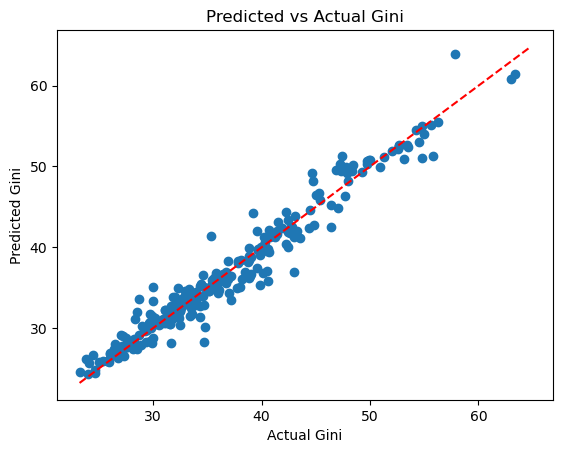

In [234]:
import matplotlib.pyplot as plt

plt.scatter(y_test, model.predict(X_test))
plt.xlabel("Actual Gini")
plt.ylabel("Predicted Gini")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.title("Predicted vs Actual Gini")
plt.show()

In [235]:
print(y_train.describe())

count    837.000000
mean      36.086858
std        7.811756
min       23.200000
25%       30.500000
50%       34.400000
75%       40.800000
max       64.800000
Name: gini, dtype: float64


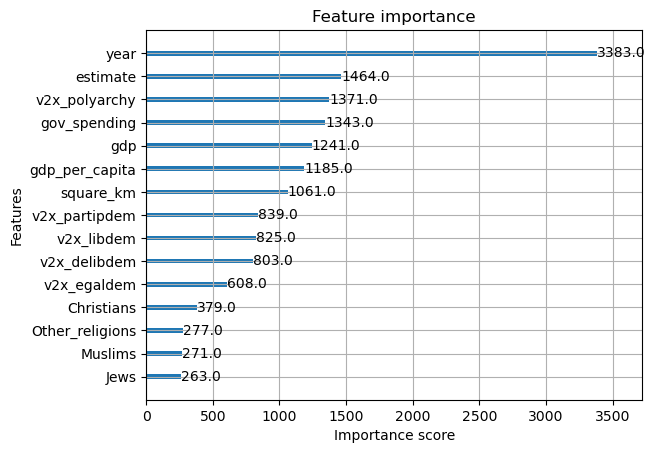

In [236]:
from xgboost import plot_importance
plot_importance(model, max_num_features=15)
plt.show()